In [1]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from cfollmer.evaluation_utils import ECE
import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.drifts import SimpleForwardNetBN
from cfollmer.sampler_utils import FollmerSDE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
a9a_train = pd.read_csv("../data/a9a.csv", header=None)
a9a_test = pd.read_csv("../data/a9a_t.csv", header=None)

In [4]:
X_train = a9a_train.values[:, :-1]
X_test = a9a_test.values[:, :-1]

y_train = a9a_train.values[:, -1]
y_test = a9a_test.values[:, -1]

X_train = torch.tensor(X_train, device=device, dtype=torch.float)
X_test = torch.tensor(X_test, device=device, dtype=torch.float)

y_train = torch.tensor(y_train, device=device, dtype=torch.float)
y_test = torch.tensor(y_test, device=device, dtype=torch.float)

X_train = F.pad(X_train, (0, 1), value=1.0)
X_test = F.pad(X_test, (0, 1), value=1.0)

N_train, dim = X_train.shape
N_test = X_test.shape[0]

In [5]:
N_train, N_test, dim

(32561, 16281, 124)

In [16]:
def log_prior(beta):
    return -torch.sum(torch.abs(beta))

def log_likelihood(x, y, beta):
    return -F.binary_cross_entropy_with_logits(x @ beta, y, reduction="sum")

def log_likelihood_batch(x, y, beta_batch):
    func = lambda beta: log_likelihood(x, y, beta)
    func = torch.vmap(func)
    return func(beta_batch)

def log_posterior(x, y, params):
    return log_prior(params) + (N_train / x.shape[0]) * log_likelihood(x, y, params)

def log_posterior_batch(x, y, beta_batch):
    func = lambda beta: log_posterior(x, y, beta)
    func = torch.vmap(func)
    return func(beta_batch)

In [7]:
gamma = 0.2**2
n_epochs = 300
data_batch_size = N_train
param_batch_size = 32

In [14]:
def train(gamma, n_epochs, data_batch_size, param_batch_size, dt=0.05):
    
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []

    for _ in tqdm(range(n_epochs)):
        epoch_losses = []

        perm = torch.randperm(N_train)
        
        for i in range(0, N_train, data_batch_size):
            x = X_train[perm[i:min(i + data_batch_size, N_train)]]
            y = y_train[perm[i:min(i + data_batch_size, N_train)]]

            optimizer.zero_grad()
            
            partial_log_p = lambda params_batch: log_posterior_batch(x, y, params_batch)
        
            loss = relative_entropy_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
            loss.backward()
            
            epoch_losses.append(loss.detach().cpu().numpy())
            optimizer.step()

        losses.append(epoch_losses)
    
    losses = np.array(losses)
    
    return sde, losses

In [15]:
sde, losses = train(gamma, n_epochs, data_batch_size, param_batch_size, dt=0.05)

  0%|                                                                        | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_623875/2473517683.py:12: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)
100%|██████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.59it/s]


In [28]:
def evaluate(beta_samples):
    with torch.no_grad():
        predict_func = lambda beta : X_test @ beta
        predict_func = torch.vmap(predict_func)
        
        out = predict_func(beta_samples)
        out = torch.sigmoid(out)
        
        probs = torch.mean(out, dim=0)
        preds = torch.round(probs)

        logp = log_likelihood_batch(X_test, y_test, beta_samples)
        logp = torch.mean(logp) / N_test
        conf = torch.max(probs, 1 - probs)
        
    logp = logp.cpu().numpy()
    probs = probs.cpu().numpy()
    preds = preds.cpu().numpy()
    conf = conf.cpu().numpy()
    
    ece = ECE(conf, preds, y_test.cpu().numpy())
    acc = np.mean(preds == y_test.cpu().numpy())
    return ece, logp, acc

In [29]:
with torch.no_grad():
    beta_samples = sde.sample(100, dt=0.01, device=device)
ece, logps, acc = evaluate(beta_samples)
ece, logps, acc

/tmp/ipykernel_623875/1020984923.py:4: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  predict_func = torch.vmap(predict_func)
/tmp/ipykernel_623875/302531964.py:9: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)


(0.008016572717761909, array(-0.33976236, dtype=float32), 0.8498863706160555)

In [31]:
n_runs = 5

eces, logps, accs = [], [], []

for i in range(n_runs):
    sde, losses = train(gamma, n_epochs, data_batch_size, param_batch_size, dt=0.05)
    with torch.no_grad():
        beta_samples = sde.sample(100, dt=0.01, device=device)
    ece, logp, acc = evaluate(beta_samples)
    
    eces.append(ece)
    logps.append(logp)
    accs.append(acc)

  0%|                                                                        | 0/300 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
/tmp/ipykernel_623875/302531964.py:17: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)
100%|█████████████████████████████████████████

In [37]:
SBP_df = pd.DataFrame({"ECE": eces, "log predictive": np.array(logps), "accuracy": accs})

In [38]:
SBP_df

,ECE,log predictive,accuracy
0,0.009620,-0.340512,0.849579
1,0.010714,-0.341152,0.849764
2,0.009434,-0.340465,0.850071
3,0.008504,-0.341286,0.849886
4,0.011104,-0.340325,0.850071


In [40]:
SBP_df.describe()

,ECE,log predictive,accuracy
count,5.000000,5.000000,5.000000
mean,0.009875,-0.340748,0.849874
std,0.001043,0.000438,0.000210
min,0.008504,-0.341286,0.849579
25%,0.009434,-0.341152,0.849764
50%,0.009620,-0.340512,0.849886
75%,0.010714,-0.340465,0.850071
max,0.011104,-0.340325,0.850071


In [41]:
@torch.enable_grad()
def gradient(x, y, beta):
    beta_ = beta.clone().requires_grad_(True)
    loss = log_posterior(x, y, beta_)
    grad, = torch.autograd.grad(loss, beta_)
    return loss.detach().cpu().numpy(), grad

In [42]:
def step_size(n):
    return 0.001 / (1 + n)**0.5

In [49]:
def sgld(n_epochs, data_batch_size):

    step = 0
    
    beta = torch.zeros(dim).float().to(device)
    losses = []
    accuracies = []
    logps = []
    beta_samples = []
    
    for _ in tqdm(range(n_epochs)):
        perm = torch.randperm(N_train)
        
        for i in range(0, N_train, data_batch_size):
            x = X_train[perm[i:min(i + data_batch_size, N_train)]]
            y = y_train[perm[i:min(i + data_batch_size, N_train)]]

            eps = step_size(step)
            loss, grad = gradient(x, y, beta)
            beta = beta + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(beta)
            step += 1
            
            losses.append(loss)
            beta_samples.append(beta)
            
            with torch.no_grad():
                test_pred = torch.round(torch.sigmoid(X_test @ beta))
                test_acc = torch.mean(1 - torch.abs(y_test - test_pred))
                logp = log_likelihood(X_test, y_test, beta) / X_test.shape[0]

                accuracies.append(test_acc.cpu().numpy())
                logps.append(logp.cpu().numpy())
                
    return beta_samples, losses, accuracies, logps, 

In [50]:
beta_samples, losses, accuracies, logps = sgld(n_epochs, data_batch_size)

100%|████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1312.69it/s]


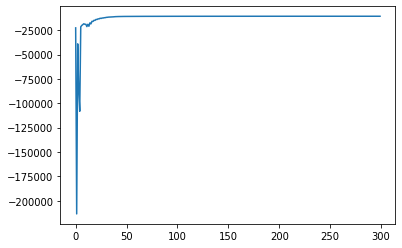

In [52]:
plt.plot(losses)

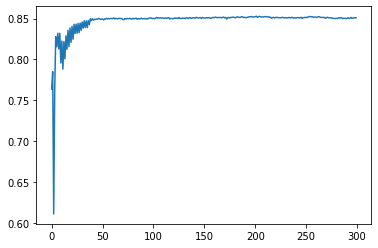

In [54]:
plt.plot(accuracies)

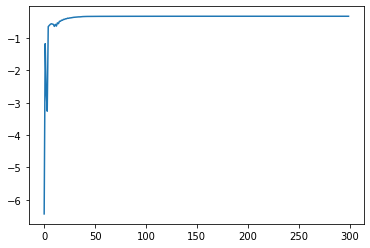

In [53]:
plt.plot(logps)

In [58]:
beta_samples = torch.stack(beta_samples[-100:])
evaluate(beta_samples)

/tmp/ipykernel_623875/1020984923.py:4: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  predict_func = torch.vmap(predict_func)
/tmp/ipykernel_623875/302531964.py:9: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)


(0.009720788296504558, array(-0.32453096, dtype=float32), 0.8512990602542841)

In [59]:
n_runs = 5

eces, logps, accs = [], [], []

for i in range(n_runs):
    beta_samples, _, _, _ = sgld(n_epochs, data_batch_size)
    beta_samples = torch.stack(beta_samples[-100:])
    ece, logp, acc = evaluate(beta_samples)
    
    eces.append(ece)
    logps.append(logp)
    accs.append(acc)

100%|████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1324.23it/s]
/tmp/ipykernel_623875/1020984923.py:4: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  predict_func = torch.vmap(predict_func)
/tmp/ipykernel_623875/302531964.py:9: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)
100%|████████████████████████████████████████████████

In [60]:
SGLD_df = pd.DataFrame({"ECE": eces, "log predictive": np.array(logps), "accuracy": accs})

In [62]:
SGLD_df

,ECE,log predictive,accuracy
0,0.009266,-0.324748,0.851053
1,0.008499,-0.325029,0.850378
2,0.008357,-0.324935,0.850316
3,0.011593,-0.324638,0.852712
4,0.012313,-0.324462,0.852835


In [63]:
SGLD_df.describe()

,ECE,log predictive,accuracy
count,5.000000,5.000000,5.000000
mean,0.010006,-0.324762,0.851459
std,0.001829,0.000227,0.001235
min,0.008357,-0.325029,0.850316
25%,0.008499,-0.324935,0.850378
50%,0.009266,-0.324748,0.851053
75%,0.011593,-0.324638,0.852712
max,0.012313,-0.324462,0.852835
